In [20]:
path = "/home/reshni/.cache/kagglehub/datasets/ahmedkhanak1995/sign-language-gesture-images-dataset/versions/1"

In [21]:
import os
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split


In [22]:
import os
import cv2
import numpy as np
from sklearn.utils import shuffle
from tensorflow.keras.utils import to_categorical

# Function to load and preprocess images from a directory
def load_images_from_folder(base_path, image_size=(50, 50)):
    images = []
    labels = []
    
    # Get a sorted list of folder names and create a label map
    class_labels = sorted(os.listdir(base_path))
    label_map = {label_name: idx for idx, label_name in enumerate(class_labels)}
    
    for label_name in class_labels:
        label_path = os.path.join(base_path, label_name)
        
        # Ensure the folder contains images and is not empty
        if not os.path.isdir(label_path):
            continue
            
        # Loop through each image in the folder
        for image_name in os.listdir(label_path):
            image_path = os.path.join(label_path, image_name)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read image as grayscale
            
            if image is not None:
                # Resize the image
                image = cv2.resize(image, image_size)
                image = image.astype('float32') / 255.0  # Normalize to range [0, 1]
                images.append(image)
                labels.append(label_map[label_name])  # Use mapped label

    return np.array(images), np.array(labels), label_map

# Load images and labels from dataset
base_path = path + '/Gesture Image Data'  # Replace with the path to your dataset
images, labels, label_map = load_images_from_folder(base_path)

# Shuffle the dataset
images, labels = shuffle(images, labels, random_state=42)

# Define the split sizes
train_size = int(0.7 * images.shape[0])  # 70% for training
val_size = int(0.15 * images.shape[0])   # 15% for validation
test_size = images.shape[0] - train_size - val_size  # Remaining for testing

# Split the dataset into training, validation, and testing sets
X_train, X_val, X_test = images[:train_size], images[train_size:train_size + val_size], images[train_size + val_size:]
y_train, y_val, y_test = labels[:train_size], labels[train_size:train_size + val_size], labels[train_size + val_size:]

# One-hot encode the labels
num_classes = len(label_map)  # Number of unique classes
y_train = to_categorical(y_train, num_classes=num_classes)
y_val = to_categorical(y_val, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

# Output the shapes of the datasets
print(f'Training set: {X_train.shape}, Validation set: {X_val.shape}, Test set: {X_test.shape}')
print(f'One-hot encoded labels shapes: y_train: {y_train.shape}, y_val: {y_val.shape}, y_test: {y_test.shape}')


Training set: (38850, 50, 50), Validation set: (8325, 50, 50), Test set: (8325, 50, 50)
One-hot encoded labels shapes: y_train: (38850, 37), y_val: (8325, 37), y_test: (8325, 37)


20


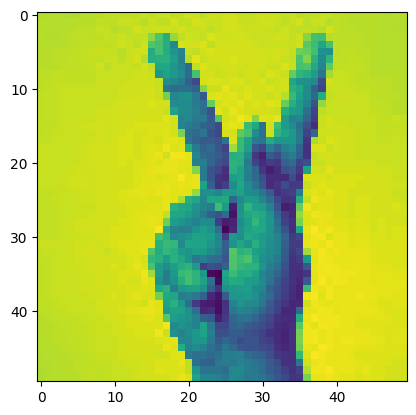

In [27]:
import matplotlib.pyplot as plt
index=123
img = images[index]
print(labels[index])

#img = cv2.resize(img, (224, 224))
plt.imshow(img)

In [203]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
#batch_size=10
#setting Training Hyperparameters
batch_size= 100
epochs=20
data_augmentation=True
# Update your checkpoint to use 'val_accuracy'
checkpoint = ModelCheckpoint("sign_lang.keras", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='max')

# Update early stopping to monitor 'val_accuracy' with mode='max'
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='max')

# Ensure your steps_per_epoch and validation_steps are set appropriately
steps_per_epoch = len(images) // batch_size  # Adjust based on your data
validation_steps = len(X_test) // batch_size   # Adjust based on your data

In [204]:
import numpy as np
from tensorflow.keras import layers, models
import tensorflow as tf

model = tf.keras.Sequential()

# Conv2D and MaxPooling layers for feature extraction
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(50, 50, 1)))  # Input shape for grayscale
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Flattening the data
model.add(layers.Flatten())  # Flatten the output of Conv2D layers

# Adding a dense layer
model.add(layers.Dense(128, activation='relu'))

# Reshape to make it suitable for LSTM input (time_steps, features)
model.add(layers.Reshape((1, 128)))  # Here, 1 is the time step, 128 is the feature

# LSTM layer for sequence modeling
model.add(layers.LSTM(128, return_sequences=False))  # LSTM layer

# Dense layer after LSTM
model.add(layers.Dense(64, activation='relu'))  # Dense layer

# Output layer with softmax activation
num_classes = len(np.unique(labels))  # Assuming 'labels' is the actual label array
model.add(layers.Dense(num_classes, activation='softmax'))  # Output layer

# Print model summary
model.summary()


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_27 (Conv2D)              │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 22, 22, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 7744)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 128)            │       991,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_12 (Reshape)            │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 37)             │         2,405 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,152,421 (4.40 MB)

 Trainable params: 1,152,421 (4.40 MB)

 Non-trainable params: 0 (0.00 B)

In [205]:
from keras.optimizers import Adam
opt = Adam(learning_rate=0.00001)

model.compile(optimizer = opt,loss='mean_squared_error',metrics=['accuracy'])
# Now you can fit your model
history = model.fit(
    x=X_train,          # Training inputs
    y=y_train,                          # Training targets
    validation_data=(X_val, y_val),  # Validation data
    steps_per_epoch=steps_per_epoch,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[checkpoint, early]
)

# Evaluate your model on the test data
# model.evaluate([test_sar, test_optical], test_optical)

Epoch 1/20
389/555 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.0495 - loss: 0.0263
Epoch 1: val_accuracy improved from -inf to 0.07459, saving model to sign_lang.keras
555/555 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - accuracy: 0.0497 - loss: 0.0263 - val_accuracy: 0.0746 - val_loss: 0.0263
Epoch 2/20
388/555 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.0938 - loss: 0.0263
Epoch 2: val_accuracy did not improve from 0.07459
555/555 ━━━━━━━━━━━━━━━━━━━━ 18s 33ms/step - accuracy: 0.0927 - loss: 0.0263 - val_accuracy: 0.0399 - val_loss: 0.0263
Epoch 3/20
388/555 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - accuracy: 0.0534 - loss: 0.0262
Epoch 3: val_accuracy improved from 0.07459 to 0.07532, saving model to sign_lang.keras
555/555 ━━━━━━━━━━━━━━━━━━━━ 25s 44ms/step - accuracy: 0.0567 - loss: 0.0262 - val_accuracy: 0.0753 - val_loss: 0.0261
Epoch 4/20
388/555 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.0988 - loss: 0.0259
Epoch 4: val_accuracy improved from 0.07532 to 0.19363, saving model to

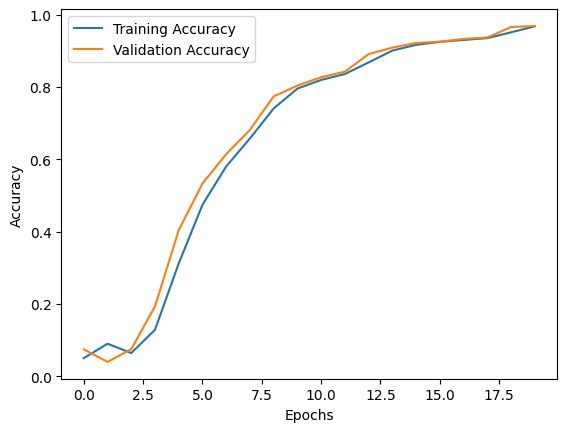

In [206]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')  # Use 'val_accuracy' here
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


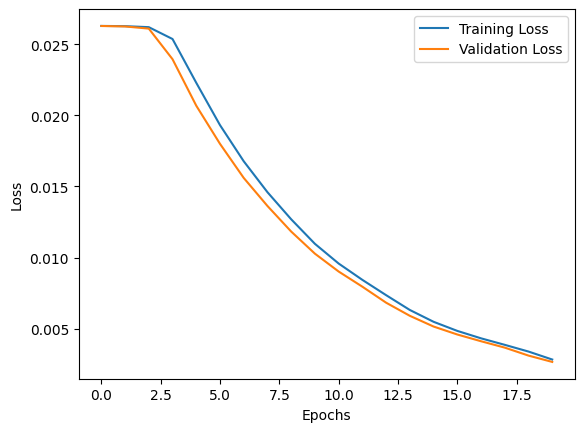

In [207]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')  # Use 'val_loss' here
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [25]:
from tensorflow.keras.models import load_model

model_ = load_model('sign_lang.keras')

# testing 

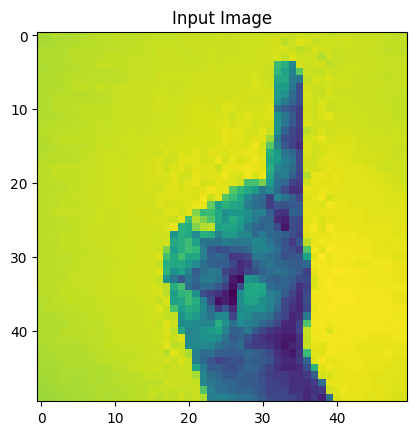

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted output: D
Actual output: D


In [31]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


# Reverse mapping from index to label
index_to_label = {v: k for k, v in label_map.items()}

index = 567# Index of the test image

# Display the input image
img_in = np.array(X_test[index])  # Get the test image at the specified index
# img_in = cv2.cvtColor(img_in, cv2.COLOR_BGR2RGB)  # Uncomment if needed to convert color channels
plt.imshow(img_in)
plt.title("Input Image")
plt.show()

# Expand the dimensions of the input image to match the model's expected input shape
input_ = np.expand_dims(X_test[index], axis=0)  # Use the image at the current index

# Predict the output using the model
y_pred = model_.predict(input_)
y_pred = np.argmax(y_pred, axis=-1)  # Get the class with the highest probability

# Get the actual output from y_test at the same index (ensure it's one-hot encoded)
actual_output = np.array(y_test[index])
actual_output = np.argmax(actual_output)  # Convert one-hot encoding to the class index

# Convert the predicted and actual outputs to labels using the mapping
predicted_label = index_to_label[y_pred[0]]
actual_label = index_to_label[actual_output]

# Print the predicted and actual output labels
print(f"Predicted output: {predicted_label}")  # Print the predicted class label
print(f"Actual output: {actual_label}")  # Print the actual class label
